### This notebook explores what is a reasonable value for $\sigma_p$ in our simulations



* Option 1 - "Andres method"
* Option 2 - Scaling law. Eq 5 of https://iopscience.iop.org/article/10.1088/1742-6596/610/1/012019/pdf

#### Option 2 



$$\sigma = C \nu^{\alpha} |\dot{\nu}|^{\beta} T^{\gamma}$$

In [59]:
alpha = 1.0 
beta = 2.0 
gamma = 2.4 
ln_C = -20


pulsars = pd.read_csv("../data/NANOGrav_pulsars.csv")
f = pulsars["F0"].to_numpy()
fdot = pulsars["F1"].to_numpy()

T = 1/52 #1 week in years 

log_sigma_mu_s = ln_C +alpha*np.log(f) +beta*np.log(np.abs(fdot*1e15))+gamma*np.log(T) 
sigma_mu_s = np.exp(log_sigma_mu_s)
sigma_s =sigma_mu_s*1e-6


In [60]:
print(np.min(sigma_s))
print(np.max(sigma_s))
print(np.median(sigma_s))

6.98647004458319e-20
1.8895681813194913e-13
1.2583619603484644e-17


In [61]:
T_sec = T*52*7*24*3600
sigma_f = f * sigma_s/T_sec

In [62]:
sigma_f

array([4.20448055e-20, 2.02383294e-21, 9.98945320e-21, 2.89646334e-20,
       5.53309496e-21, 1.30476167e-23, 6.67719600e-20, 3.43202740e-22,
       3.61115995e-21, 4.71847946e-21, 2.27344823e-21, 9.33356761e-22,
       5.90328661e-22, 1.07943217e-20, 2.45635611e-20, 2.05537860e-21,
       9.07652313e-21, 2.07193445e-21, 3.76586145e-21, 8.55792862e-20,
       4.52633690e-21, 2.25661518e-18, 4.39491886e-20, 4.20101333e-21,
       3.47432645e-21, 9.30771866e-19, 7.79010736e-20, 1.58699219e-21,
       7.58406487e-21, 8.57244625e-22, 8.01650657e-21, 2.00556737e-16,
       4.01262086e-21, 2.55860558e-21, 4.31178041e-21, 2.97464544e-22,
       2.80887545e-20, 7.27310102e-22, 3.92769791e-20, 1.34606095e-23,
       6.11122076e-20, 8.63956458e-22, 1.78924758e-20, 4.60433861e-20,
       2.54654826e-21, 9.16603396e-22, 1.95936731e-21])

In [63]:
print(np.min(sigma_f))
print(np.max(sigma_f))
print(np.median(sigma_f))

1.3047616693378626e-23
2.0055673664413628e-16
4.311780413359931e-21


### Lets create some synthetic data using these numbers

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
try:
    sys.path.remove("../py_src") # Hacky way to add higher directory to python modules path. 
except:
    pass
sys.path.append("../py_src") # Means that I dont have to make src/ a proper python package

In [6]:
from system_parameters import SystemParameters
from pulsars import Pulsars

from synthetic_data import SyntheticData
from plotting import plot_statespace,plot_all
from model import LinearModel
from kalman_filter import KalmanFilter
from bilby_wrapper import BilbySampler
from priors import priors_dict,bilby_priors_dict

Can we separate two data streams with different (small) $\sigma_p$ values?

In [189]:
#Setup the system
P1   = SystemParameters(h=1e-12,σp=1e-20,σm=1e-11,use_psr_terms_in_data=True,measurement_model="earth")# define the system parameters as a dict. Todo: make this a class
PTA1 = Pulsars(P1)                                       # setup the PTA
data1 = SyntheticData(PTA1,P1)                            # generate some synthetic data

***Welcome to the Kalman Filter Nested Sampler for PTA GW systems***
Attention: You are including the PSR terms in your synthetic data generation
No heterodyne corrections


In [190]:
#Setup the system
P2   = SystemParameters(h=1e-12,σp=1e-19,σm=1e-11,use_psr_terms_in_data=True,measurement_model="earth")# define the system parameters as a dict. Todo: make this a class
PTA2 = Pulsars(P2)                                       # setup the PTA
data2 = SyntheticData(PTA2,P2)                            # generate some synthetic data

***Welcome to the Kalman Filter Nested Sampler for PTA GW systems***
Attention: You are including the PSR terms in your synthetic data generation
No heterodyne corrections


In [191]:
f1 = data1.intrinsic_frequency
f2 = data2.intrinsic_frequency
f1 == f2 

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

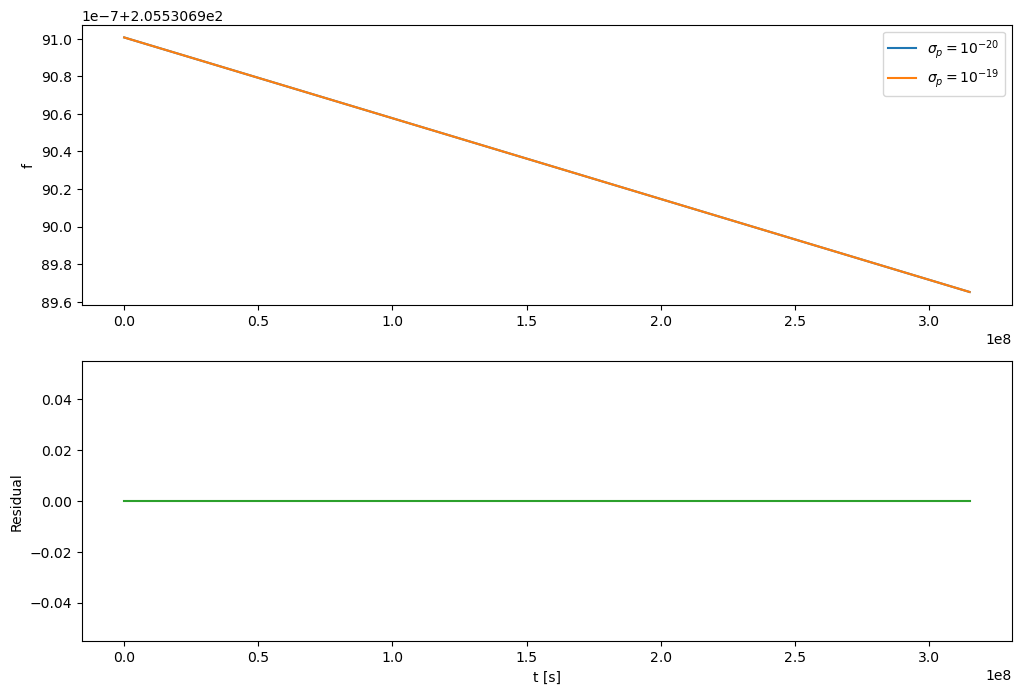

In [203]:
import matplotlib.pyplot as plt 
h,w = 12,8
rows = 2
cols = 1
fig, (ax1,ax2) = plt.subplots(nrows=rows, ncols=cols, figsize=(h,w),sharex=False)

idx = 1
ax1.plot(PTA1.t,f1[:,idx],label=r'$\sigma_p = 10^{-20}$')
ax1.plot(PTA1.t,f2[:,idx],label=r'$\sigma_p = 10^{-19}$')
ax1.legend()
ax1.set_ylabel('f')

ax2.plot(PTA1.t,f2[:,idx] -f1[:,idx],c='C2')
ax2.set_ylabel('Residual')

ax2.set_xlabel('t [s]')


plt.savefig(f"../data/images/sigma_p_non_hetero.png", bbox_inches="tight",dpi=300)



No we cannot! What if we heterodyne first?

In [204]:
import numpy as np 
import sdeint
#Setup the system
P3   = SystemParameters(h=1e-12,σp=1e-20,σm=1e-11,use_psr_terms_in_data=True,measurement_model="earth")# define the system parameters as a dict. Todo: make this a class
PTA3 = Pulsars(P3)                                       # setup the PTA

t = PTA3.t 
f0 = PTA3.f 
fdot = PTA3.fdot 
fprime = f0 - PTA3.ephemeris[0,:] 

sigma_p = np.full((PTA3.Npsr,1),PTA3.sigma_p)
gamma = PTA3.gamma

def f(x,t):
    return -gamma * x 
def g(x,t): 
    return sigma_p

generator = np.random.default_rng(1234)
heterodyned_frequency_1 = sdeint.itoint(f,g,fprime, t,generator=generator)


***Welcome to the Kalman Filter Nested Sampler for PTA GW systems***


In [205]:
import numpy as np 
import sdeint
#Setup the system
P3   = SystemParameters(h=1e-12,σp=1e-19,σm=1e-11,use_psr_terms_in_data=True,measurement_model="earth")# define the system parameters as a dict. Todo: make this a class
PTA3 = Pulsars(P3)                                       # setup the PTA

t = PTA3.t 
f0 = PTA3.f 
fdot = PTA3.fdot 
fprime = f0 - PTA3.ephemeris[0,:] 

sigma_p = np.full((PTA3.Npsr,1),PTA3.sigma_p)
gamma = PTA3.gamma

def f(x,t):
    return -gamma * x 
def g(x,t): 
    return sigma_p

generator = np.random.default_rng(1234)
heterodyned_frequency_2 = sdeint.itoint(f,g,fprime, t,generator=generator)


***Welcome to the Kalman Filter Nested Sampler for PTA GW systems***


In [206]:
f1 = heterodyned_frequency_1
f2 = heterodyned_frequency_2
f1 == f2 

array([[ True,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

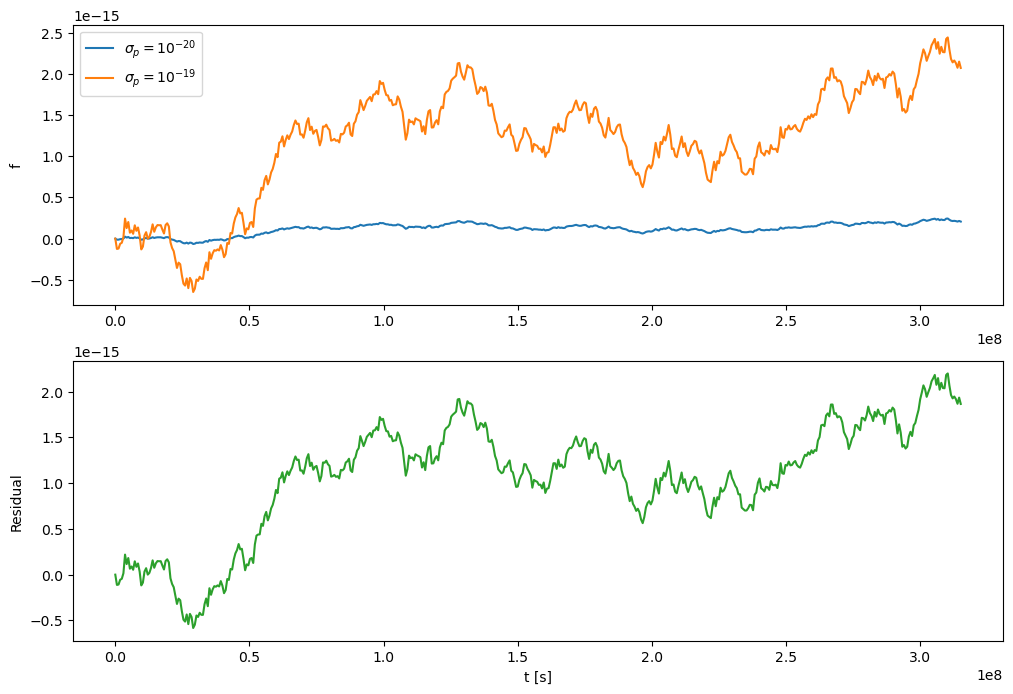

In [207]:
import matplotlib.pyplot as plt 
h,w = 12,8
rows = 2
cols = 1
fig, (ax1,ax2) = plt.subplots(nrows=rows, ncols=cols, figsize=(h,w),sharex=False)

idx = 1
ax1.plot(PTA1.t,f1[:,idx],label=r'$\sigma_p = 10^{-20}$')
ax1.plot(PTA1.t,f2[:,idx],label=r'$\sigma_p = 10^{-19}$')
ax1.legend()
ax1.set_ylabel('f')

ax2.plot(PTA1.t,f2[:,idx] -f1[:,idx],c='C2')
ax2.set_ylabel('Residual')

ax2.set_xlabel('t [s]')



plt.savefig(f"../data/images/sigma_p_hetero.png", bbox_inches="tight",dpi=300)



In [ ]:
import numpy as np 
import sdeint
#Setup the system
P3   = SystemParameters(h=1e-12,σp=1e-19,σm=1e-11,use_psr_terms_in_data=True,measurement_model="earth")# define the system parameters as a dict. Todo: make this a class
PTA3 = Pulsars(P3)                                       # setup the PTA

t = PTA3.t 
f0 = PTA3.f 
fdot = PTA3.fdot 
fprime = f0 - PTA3.ephemeris[0,:] 

sigma_p = np.full((PTA3.Npsr,1),PTA3.sigma_p)
gamma = PTA3.gamma

def f(x,t):
    return -gamma * x 
def g(x,t): 
    return sigma_p

generator = np.random.default_rng(1234)
heterodyned_frequency_2 = sdeint.itoint(f,g,fprime, t,generator=generator)


## Heterodyne expts

In [194]:

import numpy as np 
import sdeint
#Setup the system
P3   = SystemParameters(h=1e-2,σp=1e-18,σm=1e-11,use_psr_terms_in_data=True,measurement_model="earth")# define the system parameters as a dict. Todo: make this a class
PTA3 = Pulsars(P3)                                       # setup the PTA
data3 = SyntheticData(PTA3,P3)                            # generate some synthetic data

f_solution = data3.intrinsic_frequency #this is the f(t) solution 


print(f_solution - PTA3.ephemeris)

#Now get the f'(t) solution
#from mpmath import mp, mpf 
#mp.dps = 50

t = PTA3.t 
f0 = PTA3.f #* mpf(1.0)
fdot = PTA3.fdot #* mpf(1.0)
fprime = f0 - PTA3.ephemeris[0,:]#* mpf(1.0) #just = 0 


sigma_p = np.full((PTA3.Npsr,1),PTA3.sigma_p)#* mpf(1.0)
gamma = PTA3.gamma# * mpf(1.0)

def f(x,t):
    return -gamma * x 
def g(x,t): 
    return sigma_p

generator = np.random.default_rng(1234)
heterodyned_frequency_1 = sdeint.itoint(f,g,fprime, t,generator=generator)


***Welcome to the Kalman Filter Nested Sampler for PTA GW systems***
Attention: You are including the PSR terms in your synthetic data generation
No heterodyne corrections
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -5.68434189e-14 -2.84217094e-14]
 ...
 [-4.37694325e-12 -2.87059265e-12 -4.20641300e-12 ... -5.11590770e-13
  -8.75388650e-12 -6.67910172e-12]
 [-4.37694325e-12 -2.89901436e-12 -4.20641300e-12 ... -5.11590770e-13
  -8.81072992e-12 -6.67910172e-12]
 [-4.37694325e-12 -2.89901436e-12 -4.20641300e-12 ... -5.11590770e-13
  -8.81072992e-12 -6.67910172e-12]]


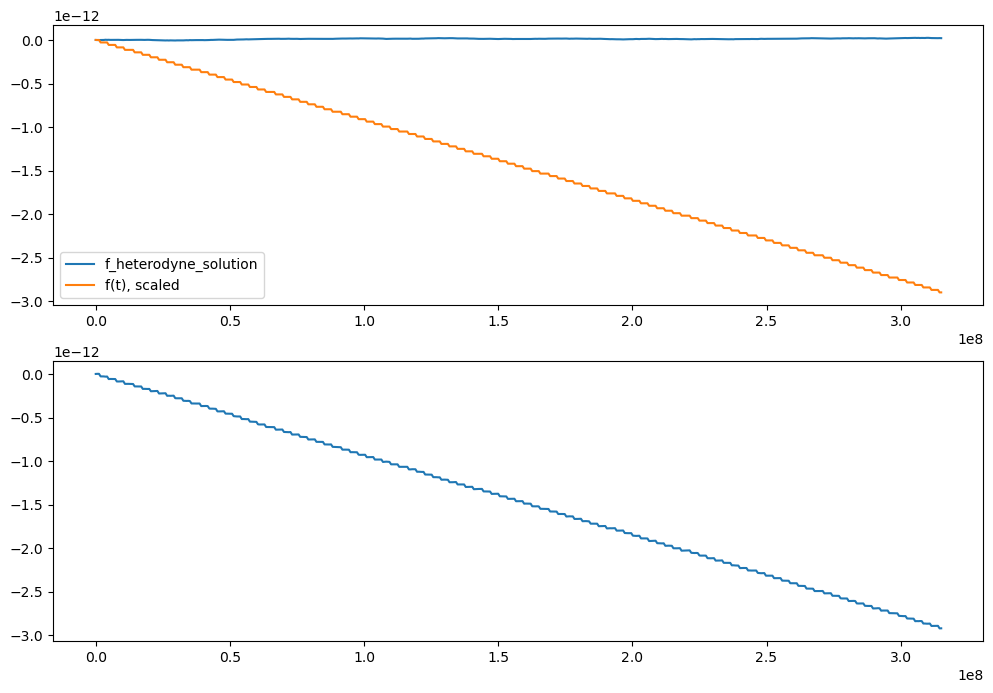

In [151]:
h,w = 12,8
rows = 2
cols = 1
fig, (ax1,ax2) = plt.subplots(nrows=rows, ncols=cols, figsize=(h,w),sharex=False)

idx = 1
ax1.plot(PTA1.t,heterodyned_frequency_1[:,idx],label='f_heterodyne_solution')

f_scaled = f_solution - PTA3.ephemeris#*mpf(1.0)
ax1.plot(PTA1.t,f_scaled[:,idx],label='f(t), scaled')
ax1.legend()

ax2.plot(PTA1.t,f_scaled[:,idx] -heterodyned_frequency_1[:,idx])



In [102]:
PTA3.ephemeris

array([[327.84702056, 205.5306991 , 303.09097941, ..., 192.59196365,
        290.25460815, 207.96816336],
       [327.84702056, 205.5306991 , 303.09097941, ..., 192.59196365,
        290.25460815, 207.96816336],
       [327.84702056, 205.5306991 , 303.09097941, ..., 192.59196365,
        290.25460815, 207.96816336],
       ...,
       [327.84702018, 205.53069897, 303.09097921, ..., 192.59196349,
        290.25460809, 207.96816323],
       [327.84702017, 205.53069897, 303.09097921, ..., 192.59196349,
        290.25460809, 207.96816323],
       [327.84702017, 205.53069897, 303.09097921, ..., 192.59196349,
        290.25460809, 207.96816323]])

In [93]:

import numpy as np 
import sdeint
#Setup the system
P3   = SystemParameters(h=1e-12,σp=1e-11,σm=1e-11,use_psr_terms_in_data=True,measurement_model="earth")# define the system parameters as a dict. Todo: make this a class
PTA3 = Pulsars(P3)                                       # setup the PTA


t = PTA3.t 
f0 = PTA3.f 
fdot = PTA3.fdot 

fprime = f0 - PTA3.ephemeris[0,:]


sigma_p = np.full((PTA3.Npsr,1),PTA3.sigma_p)
gamma = PTA3.gamma 

def f(x,t):
    return -gamma * x 
def g(x,t): 
    return sigma_p

generator = np.random.default_rng(1234)
heterodyned_frequency_2 = sdeint.itoint(f,g,fprime, t,generator=generator)


***Welcome to the Kalman Filter Nested Sampler for PTA GW systems***


In [94]:
heterodyned_frequency_1 == heterodyned_frequency_2




array([[ True,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

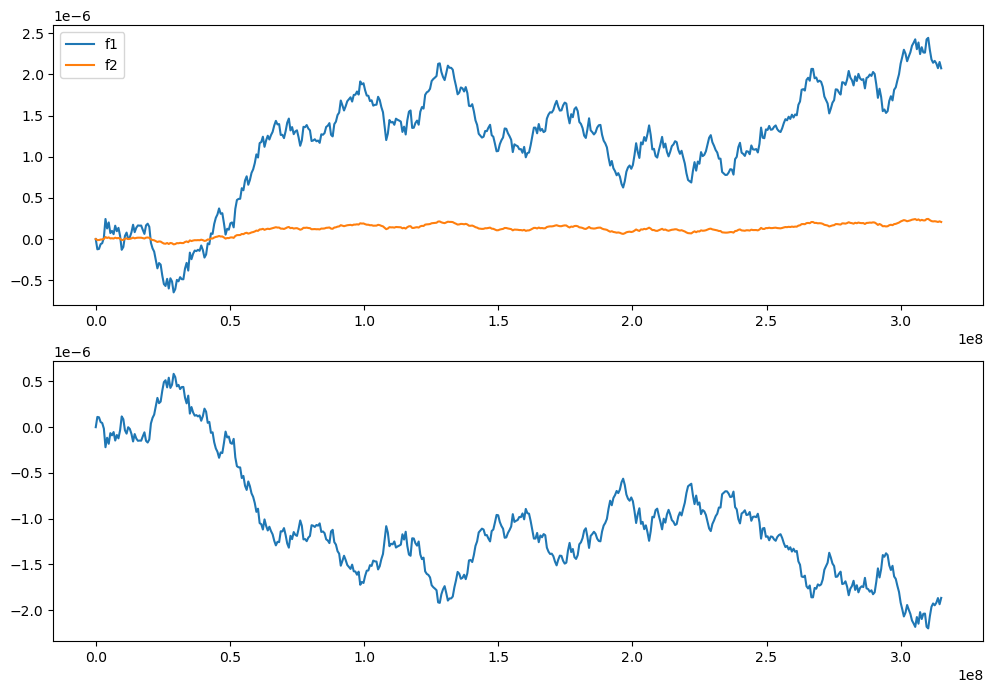

In [95]:
h,w = 12,8
rows = 2
cols = 1
fig, (ax1,ax2) = plt.subplots(nrows=rows, ncols=cols, figsize=(h,w),sharex=False)

idx = 1
ax1.plot(PTA1.t,heterodyned_frequency_1[:,idx],label='f1')
ax1.plot(PTA1.t,heterodyned_frequency_2[:,idx],label='f2')
ax1.legend()

ax2.plot(PTA1.t,heterodyned_frequency_2[:,idx] -heterodyned_frequency_1[:,idx])


In [96]:
heterodyned_frequency_1 == f1 - PTA3.ephemeris

array([[ True,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [98]:
heterodyned_frequency_1

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.24728606e-07, -1.24728606e-07, -1.24728606e-07, ...,
        -1.24728606e-07, -1.24728606e-07, -1.24728606e-07],
       [-1.19743619e-07, -1.19743619e-07, -1.19743619e-07, ...,
        -1.19743619e-07, -1.19743619e-07, -1.19743619e-07],
       ...,
       [ 2.07534974e-06,  2.07534974e-06,  2.07534974e-06, ...,
         2.07534974e-06,  2.07534974e-06,  2.07534974e-06],
       [ 2.15001422e-06,  2.15001422e-06,  2.15001422e-06, ...,
         2.15001422e-06,  2.15001422e-06,  2.15001422e-06],
       [ 2.07328553e-06,  2.07328553e-06,  2.07328553e-06, ...,
         2.07328553e-06,  2.07328553e-06,  2.07328553e-06]])

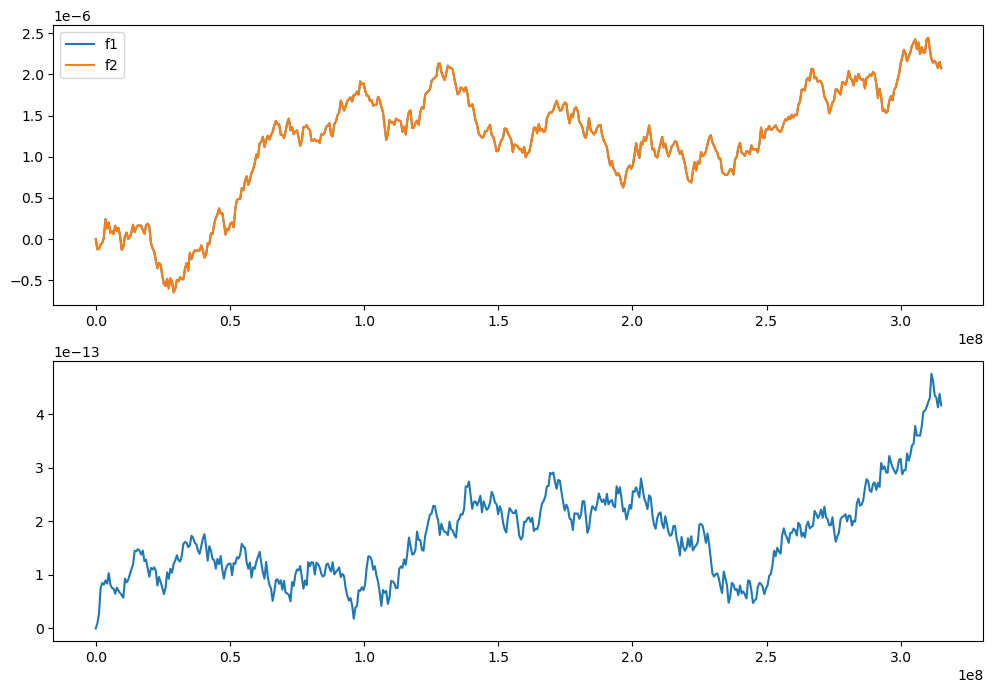

In [97]:
h,w = 12,8
rows = 2
cols = 1
fig, (ax1,ax2) = plt.subplots(nrows=rows, ncols=cols, figsize=(h,w),sharex=False)

idx = 1
ax1.plot(PTA1.t,heterodyned_frequency_1[:,idx],label='f1')

xx = f1 - PTA3.ephemeris
ax1.plot(PTA1.t,xx[:,idx],label='f2')
ax1.legend()

ax2.plot(PTA1.t,heterodyned_frequency_1[:,idx] -xx[:,idx])


### Appendix

In [ ]:






from uncertainties import ufloat
import uncertainties as unc  
import uncertainties.unumpy as unumpy 
from uncertainties.umath import exp as u_exp
import numpy as np 



def sigma_p(f,fdot,T,alpha,beta,gamma,c):

    return C*f**alpha * np.abs(fdot)**beta * T**gamma 



def log_sigma_p(f,fdot,T,alpha,beta,gamma,c):

    return np.log(C) + alpha * np.log(f) + beta*np.log(np.abs(fdot)) + gamma*np.log(T)






from uncertainties.umath import exp as u_exp
import pandas as pd 

C = ufloat(u_exp(-20),u_exp(-20)*10.0) #From uncertainty propagation rules  https://en.wikipedia.org/wiki/Propagation_of_uncertainty
alpha = ufloat(1,2.0/2) 
beta  = ufloat(2.0,1.0/2) 
gamma = ufloat(2.4,0.6/2) 



pulsars = pd.read_csv("../data/NANOGrav_pulsars.csv")
f = pulsars["F0"].to_numpy()
fdot = pulsars["F1"].to_numpy()

T = 10 * 365*24*3600
sigma_p(f,fdot,T,alpha,beta,gamma,C)


In [201]:
#Setup the system
P1   = SystemParameters(h=1e-10,σp=1e-20,σm=1e-11,use_psr_terms_in_data=True,measurement_model="earth",heterodyne=True)# define the system parameters as a dict. Todo: make this a class
PTA1 = Pulsars(P1)                                       # setup the PTA
data1 = SyntheticData(PTA1,P1)                            # generate some synthetic data

***Welcome to the Kalman Filter Nested Sampler for PTA GW systems***
Attention: You are including the PSR terms in your synthetic data generation
Heterodyning the measured data relative to a reference ephemeris


In [202]:
data1.f_measured

array([[-5.16185992e-08, -3.14124691e-08,  2.52111931e-09, ...,
         7.95125743e-10, -2.96750500e-08, -1.90510718e-09],
       [-4.50359607e-08, -3.50781022e-08,  3.42680551e-09, ...,
         1.99258920e-09, -2.68117333e-08, -5.43536771e-10],
       [-3.43897000e-08, -3.55490499e-08,  4.04884304e-09, ...,
         3.01764658e-09, -2.14863576e-08,  8.53589199e-10],
       ...,
       [-5.30520197e-08, -2.88416402e-08,  2.01060857e-09, ...,
         2.28396857e-10, -3.00855163e-08, -2.46808440e-09],
       [-4.85385385e-08, -3.38300197e-08,  3.05453796e-09, ...,
         1.46394541e-09, -2.84019848e-08, -1.16651222e-09],
       [-3.95713755e-08, -3.57329952e-08,  3.81419341e-09, ...,
         2.59362309e-09, -2.41236080e-08,  2.23991492e-10]])

In [2]:
! pip install uncertainties

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 3.6 MB/s eta 0:00:00
  Using cached future-0.18.3.tar.gz (840 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for future: filename=future-0.18.3-py3-none-any.whl size=492025 sha256=e72b7f25e75fc872815daadbf067c987cf951ba17e16258fd24359ea184aff5a
  Stored in directory: /Users/t1/Library/Caches/pip/wheels/5e/a9/47/f118e66afd12240e4662752cc22cefae5d97275623aa8ef57d
Successfully built future
